In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from explore import *

from sklearn.model_selection import train_test_split
from scipy import stats

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Plan

Purpose:
1. Develop KPI's
2. Provide 2-4 actionable suggestions to improve efficiency

## Acquire

In [2]:
df = pd.read_csv('doma_order_data.csv')
df.head()

,Order_ID,Revenue_Month,Sales_Rep,Escrow_Officer,Transaction_Type,Property_Type,Cost_Center,Order_Type,Net_Revenue
0,6,2017-01,24,10,Resale,Residential,32300,Both,1680.43
1,14,2017-01,15,10,Resale,Residential,32300,Both,1293.82
2,32,2017-01,24,10,Resale,Residential,32300,Both,2281.00
3,35,2017-01,24,10,Resale,Residential,32300,Both,1613.86
4,1522,2017-01,21,26,Refinance,Residential,32400,Both,648.11


##### Takeaways
1. Revenue change dtype to timedate
2. Drop order ID
3. Lower case

##### Initial Thoughts
1. Net Revenue by month, sales_rep, escrow_officer
2. Encode property type, order type and change dtype
3. Group by transaction type
4. check for outliers
5. explore and develop hypothesis then test (type of stat test??)


## Prepare

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Order_ID,9709.0,4842.459265,2791.709888,1.0,2426.00,4849.00,7261.00,9673.00
Sales_Rep,9709.0,17.753425,10.335312,0.0,10.00,17.00,26.00,35.00
Escrow_Officer,9709.0,20.031311,13.671888,0.0,6.00,20.00,32.00,43.00
Cost_Center,9709.0,34232.001236,1511.050056,32300.0,32400.00,33700.00,35500.00,36800.00
Net_Revenue,9709.0,1920.700697,1679.690498,0.0,1183.32,1919.73,2359.02,88506.51


##### Takeaways
1. Avg sale 1920.70
2. count number of sales rep
3. count number of escrow officers

In [4]:
df.shape

(9709, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          9709 non-null   int64  
 1   Revenue_Month     9709 non-null   object 
 2   Sales_Rep         9709 non-null   int64  
 3   Escrow_Officer    9709 non-null   int64  
 4   Transaction_Type  9709 non-null   object 
 5   Property_Type     9709 non-null   object 
 6   Cost_Center       9709 non-null   int64  
 7   Order_Type        9709 non-null   object 
 8   Net_Revenue       9709 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 682.8+ KB


##### Takeaways
1. dtypes look good.
2. encode and change dtypes. (Encode property type, order type and change dtype)

In [6]:
#check for nulls just in case.
df.isnull().sum()

Order_ID            0
Revenue_Month       0
Sales_Rep           0
Escrow_Officer      0
Transaction_Type    0
Property_Type       0
Cost_Center         0
Order_Type          0
Net_Revenue         0
dtype: int64

In [7]:
#drop duplicates if any
df = df.drop_duplicates()
df.shape

(9709, 9)

##### Takaways
1. No duplicates

In [8]:
#Now that there are no duplicates, drop order_id, all purchases are unique
df = df.drop(columns='Order_ID')
df.head()

,Revenue_Month,Sales_Rep,Escrow_Officer,Transaction_Type,Property_Type,Cost_Center,Order_Type,Net_Revenue
0,2017-01,24,10,Resale,Residential,32300,Both,1680.43
1,2017-01,15,10,Resale,Residential,32300,Both,1293.82
2,2017-01,24,10,Resale,Residential,32300,Both,2281.00
3,2017-01,24,10,Resale,Residential,32300,Both,1613.86
4,2017-01,21,26,Refinance,Residential,32400,Both,648.11


In [9]:
#converts revenue_month to datetime dtype
df['Revenue_Month'] = pd.to_datetime(df['Revenue_Month'])
df.head()

,Revenue_Month,Sales_Rep,Escrow_Officer,Transaction_Type,Property_Type,Cost_Center,Order_Type,Net_Revenue
0,2017-01-01,24,10,Resale,Residential,32300,Both,1680.43
1,2017-01-01,15,10,Resale,Residential,32300,Both,1293.82
2,2017-01-01,24,10,Resale,Residential,32300,Both,2281.00
3,2017-01-01,24,10,Resale,Residential,32300,Both,1613.86
4,2017-01-01,21,26,Refinance,Residential,32400,Both,648.11


In [11]:
doma_nedf = df
doma_nedf.to_csv('/Users/hector/Desktop/doma/doma_nedf.csv')

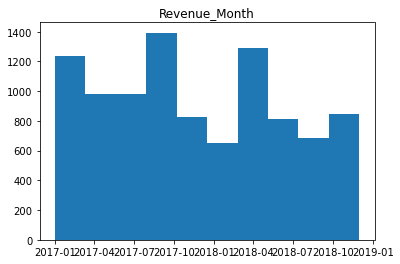

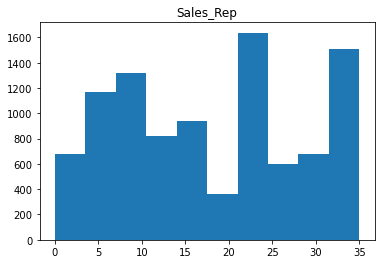

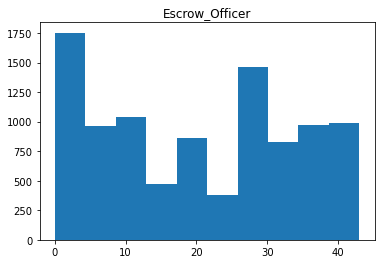

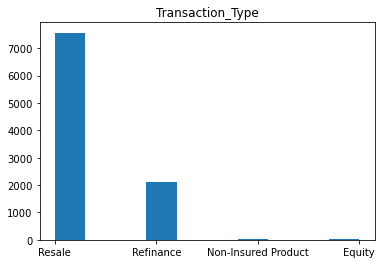

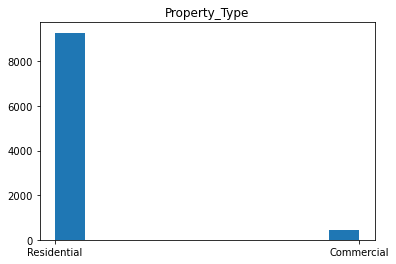

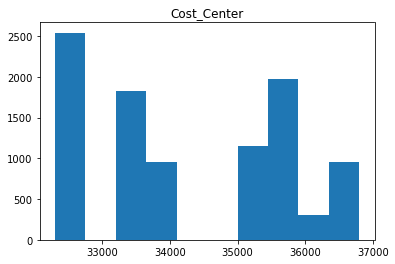

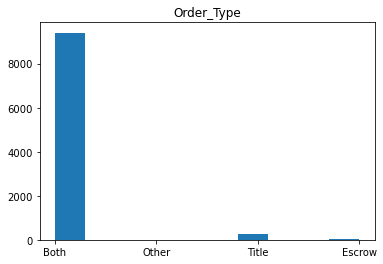

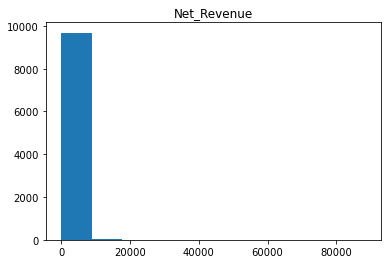

In [10]:
#get an initial view of the data
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

##### Takeaways
1. drop  non insure and equity from transaction type - low numbers will not affect recommendations
2. drop other and escrow in order type - based on data library

In [12]:
#encodes property_type, order_type, transaction_type then renames columns 'residential', 'title', and 'resale' respectively
dummy_df = pd.get_dummies(df[['Property_Type', 'Order_Type', 'Transaction_Type']], dummy_na=False, drop_first=[True, True])
dummy_df.head()

,Property_Type_Residential,Order_Type_Escrow,Order_Type_Other,Order_Type_Title,Transaction_Type_Non-Insured Product,Transaction_Type_Refinance,Transaction_Type_Resale
0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1
2,1,0,0,0,0,0,1
3,1,0,0,0,0,0,1
4,1,0,0,0,0,1,0


In [13]:
#combines 'dummy_df' with 'df'
df = pd.concat([df, dummy_df], axis=1)
df.head()

,Revenue_Month,Sales_Rep,Escrow_Officer,Transaction_Type,Property_Type,Cost_Center,Order_Type,Net_Revenue,Property_Type_Residential,Order_Type_Escrow,Order_Type_Other,Order_Type_Title,Transaction_Type_Non-Insured Product,Transaction_Type_Refinance,Transaction_Type_Resale
0,2017-01-01,24,10,Resale,Residential,32300,Both,1680.43,1,0,0,0,0,0,1
1,2017-01-01,15,10,Resale,Residential,32300,Both,1293.82,1,0,0,0,0,0,1
2,2017-01-01,24,10,Resale,Residential,32300,Both,2281.00,1,0,0,0,0,0,1
3,2017-01-01,24,10,Resale,Residential,32300,Both,1613.86,1,0,0,0,0,0,1
4,2017-01-01,21,26,Refinance,Residential,32400,Both,648.11,1,0,0,0,0,1,0


In [14]:
#drops encoded columns not needed for the analysis
df = df.drop(columns = ['Property_Type', 'Order_Type', 'Transaction_Type', 'Order_Type_Escrow', 'Order_Type_Other',
                       'Transaction_Type_Non-Insured Product', 'Transaction_Type_Refinance'])
df.head()

,Revenue_Month,Sales_Rep,Escrow_Officer,Cost_Center,Net_Revenue,Property_Type_Residential,Order_Type_Title,Transaction_Type_Resale
0,2017-01-01,24,10,32300,1680.43,1,0,1
1,2017-01-01,15,10,32300,1293.82,1,0,1
2,2017-01-01,24,10,32300,2281.00,1,0,1
3,2017-01-01,24,10,32300,1613.86,1,0,1
4,2017-01-01,21,26,32400,648.11,1,0,0


In [15]:
#sets all column names to lowercase    
df = df.rename(str.lower, axis='columns')
df.head()

,revenue_month,sales_rep,escrow_officer,cost_center,net_revenue,property_type_residential,order_type_title,transaction_type_resale
0,2017-01-01,24,10,32300,1680.43,1,0,1
1,2017-01-01,15,10,32300,1293.82,1,0,1
2,2017-01-01,24,10,32300,2281.00,1,0,1
3,2017-01-01,24,10,32300,1613.86,1,0,1
4,2017-01-01,21,26,32400,648.11,1,0,0


In [16]:
#renames encoded columns
df = df.rename(columns = {'property_type_residential':'residential', 'order_type_title':'title', 'transaction_type_resale':'resale'})
df.head()

,revenue_month,sales_rep,escrow_officer,cost_center,net_revenue,residential,title,resale
0,2017-01-01,24,10,32300,1680.43,1,0,1
1,2017-01-01,15,10,32300,1293.82,1,0,1
2,2017-01-01,24,10,32300,2281.00,1,0,1
3,2017-01-01,24,10,32300,1613.86,1,0,1
4,2017-01-01,21,26,32400,648.11,1,0,0


In [17]:
#count values of each column
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- revenue_month ---
2017-06-01    522
2017-03-01    507
2017-05-01    507
2018-05-01    479
2017-04-01    477
2017-08-01    466
2017-09-01    465
2017-10-01    462
2017-07-01    460
2018-06-01    433
2017-12-01    417
2017-01-01    409
2017-11-01    408
2018-03-01    407
2018-04-01    407
2018-07-01    378
2018-08-01    376
2018-01-01    331
2018-10-01    331
2017-02-01    323
2018-02-01    321
2018-09-01    308
2018-11-01    269
2018-12-01    246
Name: revenue_month, dtype: int64
---- sales_rep ---
21    897
10    883
12    810
34    720
4     594
26    593
5     568
33    557
17    527
29    430
24    429
7     396
15    374
3     371
19    293
1     261
32    231
30    215
22    156
23    155
18     37
2      36
16     35
8      31
20     31
28     28
0      12
27      9
9       8
13      6
6       5
11      5
35      2
31      2
14      1
25      1
Name: sales_rep, dtype: int64
---- escrow_officer ---
26    927
1     805
10    746
20    613
42    522
5     514
38    383
4     37

##### Takeaways
##### ***Offer only title and escrow only. Cost increases by?***
##### ***Is there a correlation between monthly sales and centers, reps and centers, officer and centers, or sales to rep by ?, sales to officer by ?***
1. Avg sales per month
2. Identify slower months
3. Avg sales per sales rep (& escrow officer)
4. Identify possible unknows for lower avg sales per rep (& escrow officer)
5. Possibly drop "non insured and Equity" due to size and encode transaction type

In [18]:
df.value_counts(df.net_revenue == 0)

net_revenue
False    9696
True       13
dtype: int64

##### Takeaways
1. did a value count of net sales that are equal to zero. 13 with no sales.
2. drop rows with zero net_revenue.

In [19]:
df = df[(df.net_revenue != 0)]
df.head()

,revenue_month,sales_rep,escrow_officer,cost_center,net_revenue,residential,title,resale
0,2017-01-01,24,10,32300,1680.43,1,0,1
1,2017-01-01,15,10,32300,1293.82,1,0,1
2,2017-01-01,24,10,32300,2281.00,1,0,1
3,2017-01-01,24,10,32300,1613.86,1,0,1
4,2017-01-01,21,26,32400,648.11,1,0,0


In [20]:
df.value_counts(df.net_revenue == 0)

net_revenue
False    9696
dtype: int64

In [21]:
df = df[(df.net_revenue < 40000)]
df.shape

(9692, 8)

##### Takeaway
1. dropped 13 rows with 0 value
2. dropped another 4 rows above 40000 (outliers)

In [22]:
df.shape

(9692, 8)

In [23]:
for c in dummy_df.columns:
    print ("---- %s ---" % c)
    print (dummy_df[c].value_counts())

---- Property_Type_Residential ---
1    9286
0     423
Name: Property_Type_Residential, dtype: int64
---- Order_Type_Escrow ---
0    9694
1      15
Name: Order_Type_Escrow, dtype: int64
---- Order_Type_Other ---
0    9699
1      10
Name: Order_Type_Other, dtype: int64
---- Order_Type_Title ---
0    9430
1     279
Name: Order_Type_Title, dtype: int64
---- Transaction_Type_Non-Insured Product ---
0    9683
1      26
Name: Transaction_Type_Non-Insured Product, dtype: int64
---- Transaction_Type_Refinance ---
0    7610
1    2099
Name: Transaction_Type_Refinance, dtype: int64
---- Transaction_Type_Resale ---
1    7569
0    2140
Name: Transaction_Type_Resale, dtype: int64


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9692 entries, 0 to 9708
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   revenue_month   9692 non-null   datetime64[ns]
 1   sales_rep       9692 non-null   int64         
 2   escrow_officer  9692 non-null   int64         
 3   cost_center     9692 non-null   int64         
 4   net_revenue     9692 non-null   float64       
 5   residential     9692 non-null   uint8         
 6   title           9692 non-null   uint8         
 7   resale          9692 non-null   uint8         
dtypes: datetime64[ns](1), float64(1), int64(3), uint8(3)
memory usage: 482.7 KB


In [25]:
#convert 'uint8' to 'int64'
convert_dict_int = {'residential': int, 'title':int, 'resale':int}
df = df.astype(convert_dict_int)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9692 entries, 0 to 9708
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   revenue_month   9692 non-null   datetime64[ns]
 1   sales_rep       9692 non-null   int64         
 2   escrow_officer  9692 non-null   int64         
 3   cost_center     9692 non-null   int64         
 4   net_revenue     9692 non-null   float64       
 5   residential     9692 non-null   int64         
 6   title           9692 non-null   int64         
 7   resale          9692 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 681.5 KB


In [27]:
doma_df = df
doma_df.to_csv('/Users/hector/Desktop/doma/doma_df.csv')

## Explore

In [28]:
#plots histogram
def get_hist(df):
    ''' Gets histographs of acquired continuous variables'''
    
    plt.figure(figsize=(16, 3))

    # List of columns
    cols = [col for col in df.columns if col not in ['revenue_month']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display histogram for column.
        df[col].hist(bins=5)

        # Hide gridlines.
        plt.grid(False)

        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)

        plt.tight_layout()

    plt.show()

In [29]:
#Gets box plots of acquired continuous variables (non-categorical - object)
def get_box(df):
    ''' Gets boxplots of acquired continuous variables'''
    
    # List of columns
    cols = ['sales_rep', 'escrow_officer', 'cost_center', 'net_revenue', 'residential', 'title', 'resale']

    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):

        # i starts at 0, but plot should start at 1
        plot_number = i + 1 

        # Create subplot.
        plt.subplot(1, len(cols), plot_number)

        # Title with column name.
        plt.title(col)

        # Display boxplot for column.
        sns.boxplot(data=df[[col]])

        # Hide gridlines.
        plt.grid(False)

        # sets proper spacing between plots
        plt.tight_layout()

    plt.show()

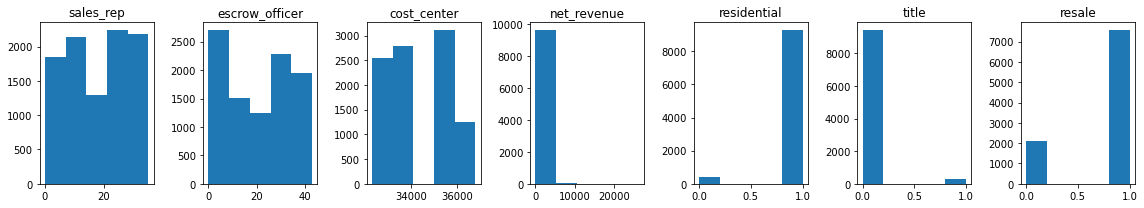

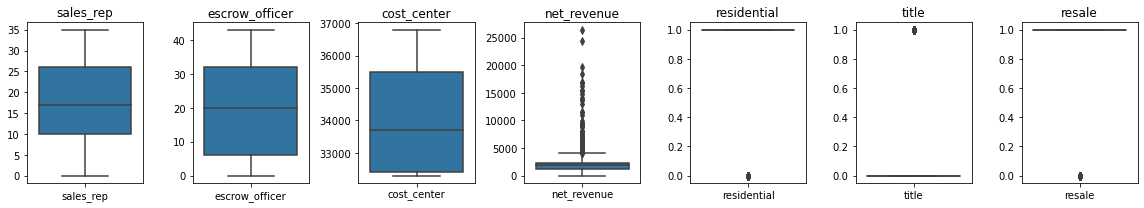

In [30]:
get_hist(df)
get_box(df)

##### Takeaways
1. identified possible outliers:
    - net_revenue
    - residential
    - title
    - resale
2. outliers/data too close to remove

### Split the dataset

In [31]:
#train, validate, test 
def target_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=seed)
    return train, validate, test

In [32]:
train, validate, test = target_split(df, 'residential', seed=123)

In [33]:
train.shape

(5427, 8)

In [34]:
validate.shape

(2326, 8)

In [35]:
test.shape

(1939, 8)

In [36]:
quant_vars = ['net_revenue', 'cost_center', 'sales_rep', 'escrow_officer']
cat_vars = ['residential', 'title', 'resale']

#### Univariate

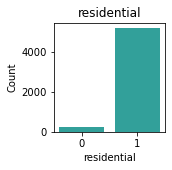

   residential  Count  Percent
1            1   5208    95.96
0            0    219     4.04
_________________________________________________________________


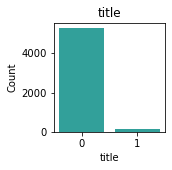

   title  Count  Percent
0      0   5281    97.31
1      1    146     2.69
_________________________________________________________________


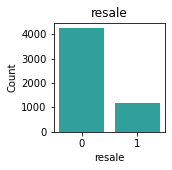

   resale  Count  Percent
1       0   4238    78.09
0       1   1189    21.91
_________________________________________________________________


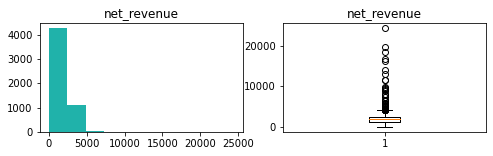

count     5427.000000
mean      1898.012053
std       1007.010443
min          5.080000
25%       1183.320000
50%       1920.750000
75%       2364.770000
max      24379.680000
Name: net_revenue, dtype: float64


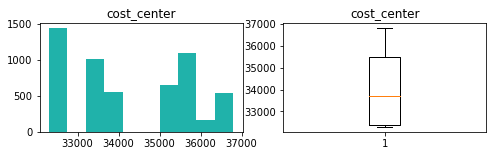

count     5427.000000
mean     34223.751612
std       1512.630715
min      32300.000000
25%      32400.000000
50%      33700.000000
75%      35500.000000
max      36800.000000
Name: cost_center, dtype: float64


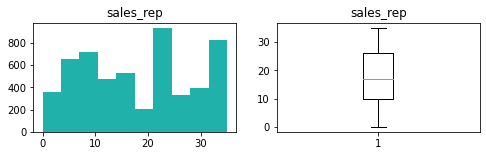

count    5427.000000
mean       17.817579
std        10.260839
min         0.000000
25%        10.000000
50%        17.000000
75%        26.000000
max        35.000000
Name: sales_rep, dtype: float64


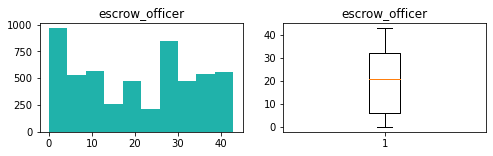

count    5427.000000
mean       20.157914
std        13.613712
min         0.000000
25%         6.000000
50%        21.000000
75%        32.000000
max        43.000000
Name: escrow_officer, dtype: float64


In [37]:
explore_univariate(train, cat_vars, quant_vars)

#### Bivariate

residential 
_____________________

          chi2  p-value  degrees of freedom
0  5401.207845      0.0                   1

observed:
 residential    0     1   All
residential                 
0            219     0   219
1              0  5208  5208
All          219  5208  5427

expected:
             0            1
0    8.837479   210.162521
1  210.162521  4997.837479


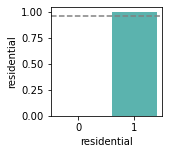


_____________________

title 
_____________________

        chi2       p-value  degrees of freedom
0  69.883931  6.289877e-17                   1

observed:
 residential    0     1   All
title                       
0            193  5088  5281
1             26   120   146
All          219  5208  5427

expected:
             0            1
0  213.108347  5067.891653
1    5.891653   140.108347


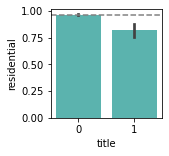


_____________________

resale 
_____________________

        chi2       p-value  degrees of freedom
0  57.625357  3.171111e-14                   1

observed:
 residential    0     1   All
resale                      
0             94  1095  1189
1            125  4113  4238
All          219  5208  5427

expected:
             0            1
0   47.980652  1141.019348
1  171.019348  4066.980652


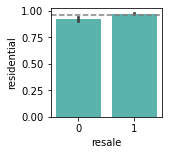


_____________________

net_revenue 
____________________



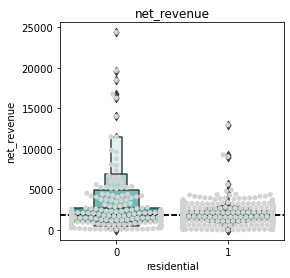

              count         mean          std    min        25%      50%  \
residential                                                                
0             219.0  2658.328356  3349.426744  32.61   964.6900  1779.21   
1            5208.0  1866.040227   749.464043   5.08  1188.0825  1928.18   

                  75%       max  
residential                      
0            2678.315  24379.68  
1            2360.350  12952.14   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=552300.5, pvalue=0.4287244985726968)

____________________

cost_center 
____________________



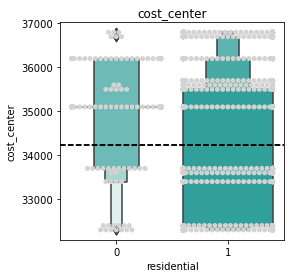

              count          mean          std      min      25%      50%  \
residential                                                                 
0             219.0  35004.566210   921.992840  32300.0  35100.0  35100.0   
1            5208.0  34190.917819  1523.802594  32300.0  32400.0  33700.0   

                 75%      max  
residential                    
0            35100.0  36800.0  
1            35500.0  36800.0   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=707103.5, pvalue=1.3687503468746535e-09)

____________________

sales_rep 
____________________



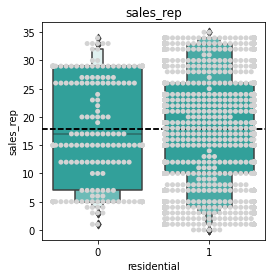

              count       mean        std  min   25%   50%   75%   max
residential                                                           
0             219.0  18.091324   9.985350  1.0   7.0  17.0  29.0  34.0
1            5208.0  17.806068  10.273036  0.0  10.0  17.0  26.0  35.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=581582.5, pvalue=0.6179469386216767)

____________________

escrow_officer 
____________________



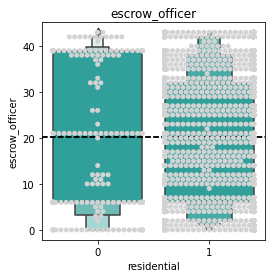

              count       mean        std  min  25%   50%   75%   max
residential                                                          
0             219.0  20.205479  16.108541  0.0  6.0  21.0  39.0  43.0
1            5208.0  20.155914  13.500524  0.0  6.0  21.0  32.0  43.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=584940.0, pvalue=0.5179098347251858)

____________________



In [38]:
explore_bivariate(train, 'residential', cat_vars, quant_vars)

## Hypothesis Testing

In [39]:
alpha = .05

Chi2 (compare two categorical variables)
1. Are title orders dependent on resales?
2. Are title orders dependent on residential sales?

In [40]:
Null = 'Title orders ARE dependent on resales'
Alternate = 'Title orders ARE NOT dependent on resales'

observed = pd.crosstab(train.title, train.resale)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 293.8418
p     = 0.0000


We reject the null and accept the alternate: Title orders ARE NOT dependent on resales


In [41]:
Null = 'Title orders ARE dependent on residential properties'
Alternate = 'Title orders ARE NOT dependent on residential properties'

observed = pd.crosstab(train.title, train.resale)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 293.8418
p     = 0.0000


We reject the null and accept the alternate: Title orders ARE NOT dependent on residential properties


TTest Two Sample (t-test to compare the means between two different supgroups.)
1. null: There is no difference in net_revenue for residential and commercial property types

2. null: There is no difference in net_revenue for title and title & escrow order types.

3. null: There is no difference in net_revenue for resale and refinance orders. 

In [42]:
Null = 'There is NO difference in net_revenue for residential and commercial property types'
Alternate = 'There IS difference in net_revenue for residential and commercial property types'

residential = train[train['residential'] == 1]
commercial = train[train['residential'] == 0]
test_results = stats.ttest_ind(residential.net_revenue, commercial.net_revenue)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 293.8418
p     = 0.0000


We reject the null and accept the alternate: There IS difference in net_revenue for residential and commercial property types


In [43]:
Null = 'There is NO difference in net_revenue for title and title & escrow order types.'
Alternate = 'There IS difference in net_revenue for title and title & escrow order types.'

title = train[train['title'] == 1]
both = train[train['title'] == 0]
test_results = stats.ttest_ind(title.net_revenue, both.net_revenue)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 293.8418
p     = 0.0000


We reject the null and accept the alternate: There IS difference in net_revenue for title and title & escrow order types.


In [44]:
Null = 'There is NO difference in net_revenue for resale and refinance orders.'
Alternate = 'There IS difference in net_revenue for resale and refinance orders.'

resale = train[train['resale'] == 1]
refinance = train[train['resale'] == 0]
test_results = stats.ttest_ind(resale.net_revenue, refinance.net_revenue)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 293.8418
p     = 0.0000


We reject the null and accept the alternate: There IS difference in net_revenue for resale and refinance orders.


#### Multivariate

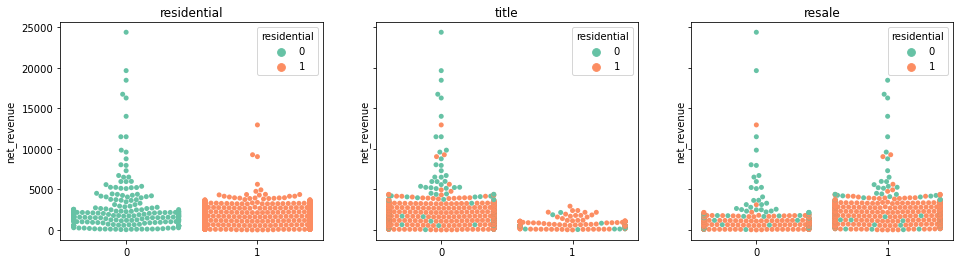

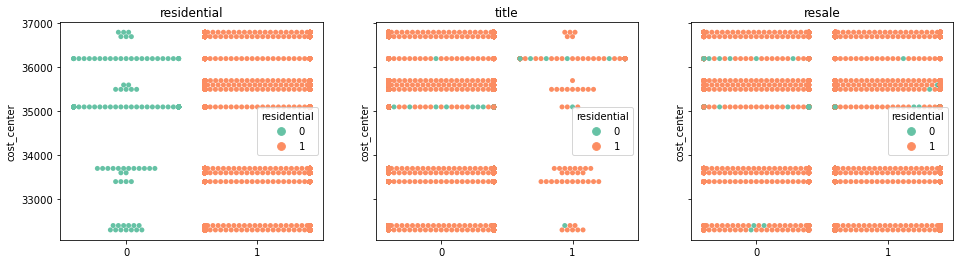

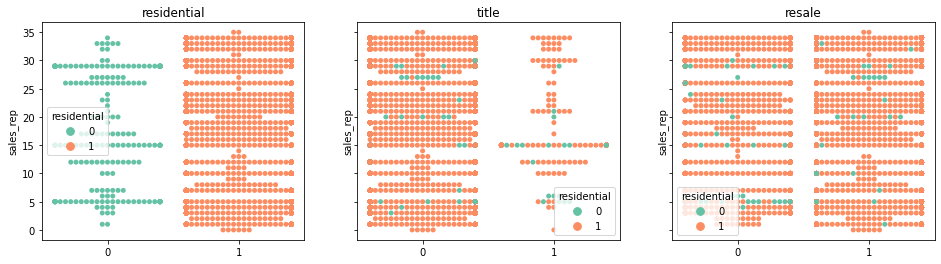

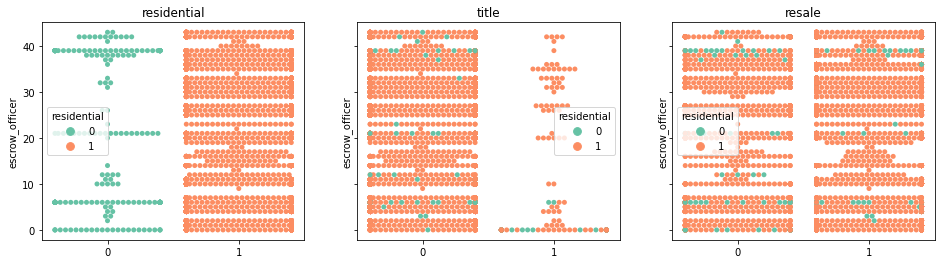

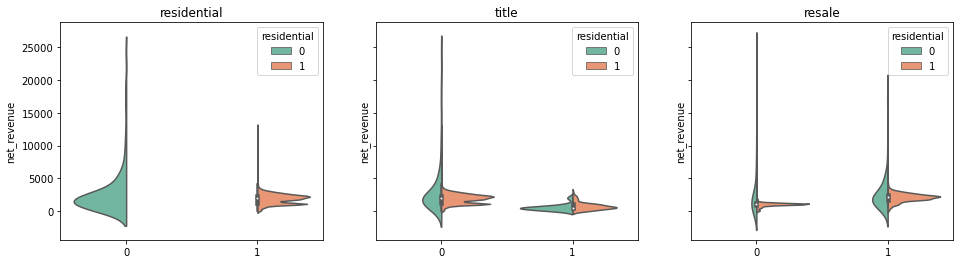

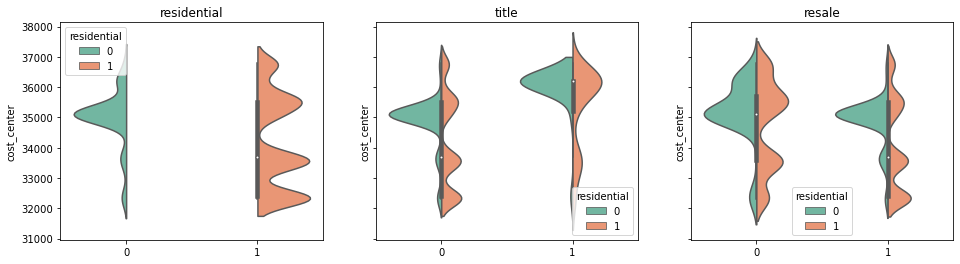

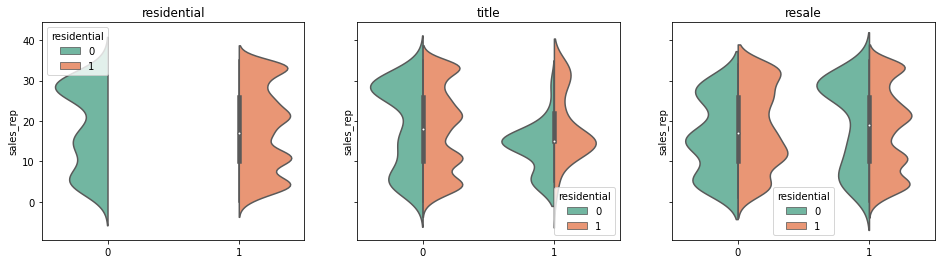

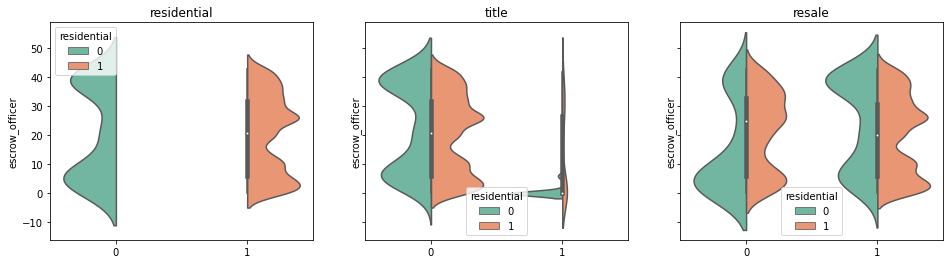

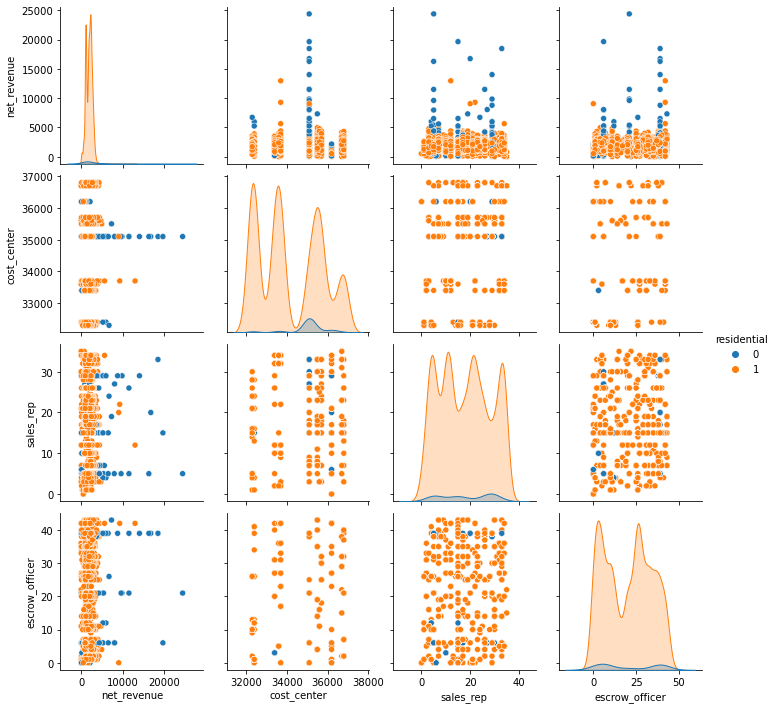

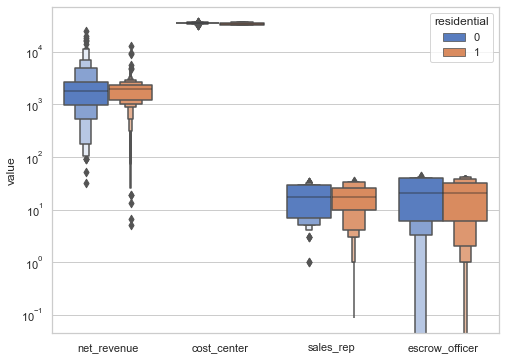

In [45]:
explore_multivariate(train, 'residential', cat_vars, quant_vars)

##### Key takeaways
1. 334, 355, 357 make up less than four percent of orders
    - Unknowns: location of these three locations
        - Question: Does location affect sales?
2. Residential orders make 4.5% of sales.
    - Drop residential orders
        - Question: Will dropping residential orders decrease sales?
    -Unknown: cost difference in marketing residential orders over cost of orders.
3. Order type 'Title' makes up 2.9% of orders.
    - Drop title orders and only provide both.
        - Question: Will dropping title orders decrease sales?
    - Unknown: cost difference in marketing title orders over cost of orders.
4. Resale makes up 78% of orders
    - Refinance makes up 22%
    - Keep: focus refinance in different areas
        - Question: In what cost center does refinance do better? - Does location make a difference in refinance orders?
5. Drop outliers
6. Sales reps (15 with less than 100 orders)
        - Question: Are they in bad locations?
    - sales rep by location
7. Escrow Officer (18 with less than 100 orders)
        - location? escrow officer to laction
    - Unkown: Excrow Officer duties, full/part time employees, self-employed       

<AxesSubplot:xlabel='net_revenue', ylabel='Density'>

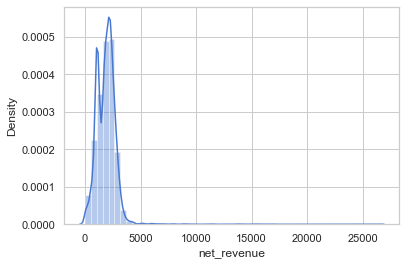

In [46]:
sns.distplot(df.net_revenue)

In [47]:
df.net_revenue.mean(), df.net_revenue.median()

(1896.815133099465, 1920.62)

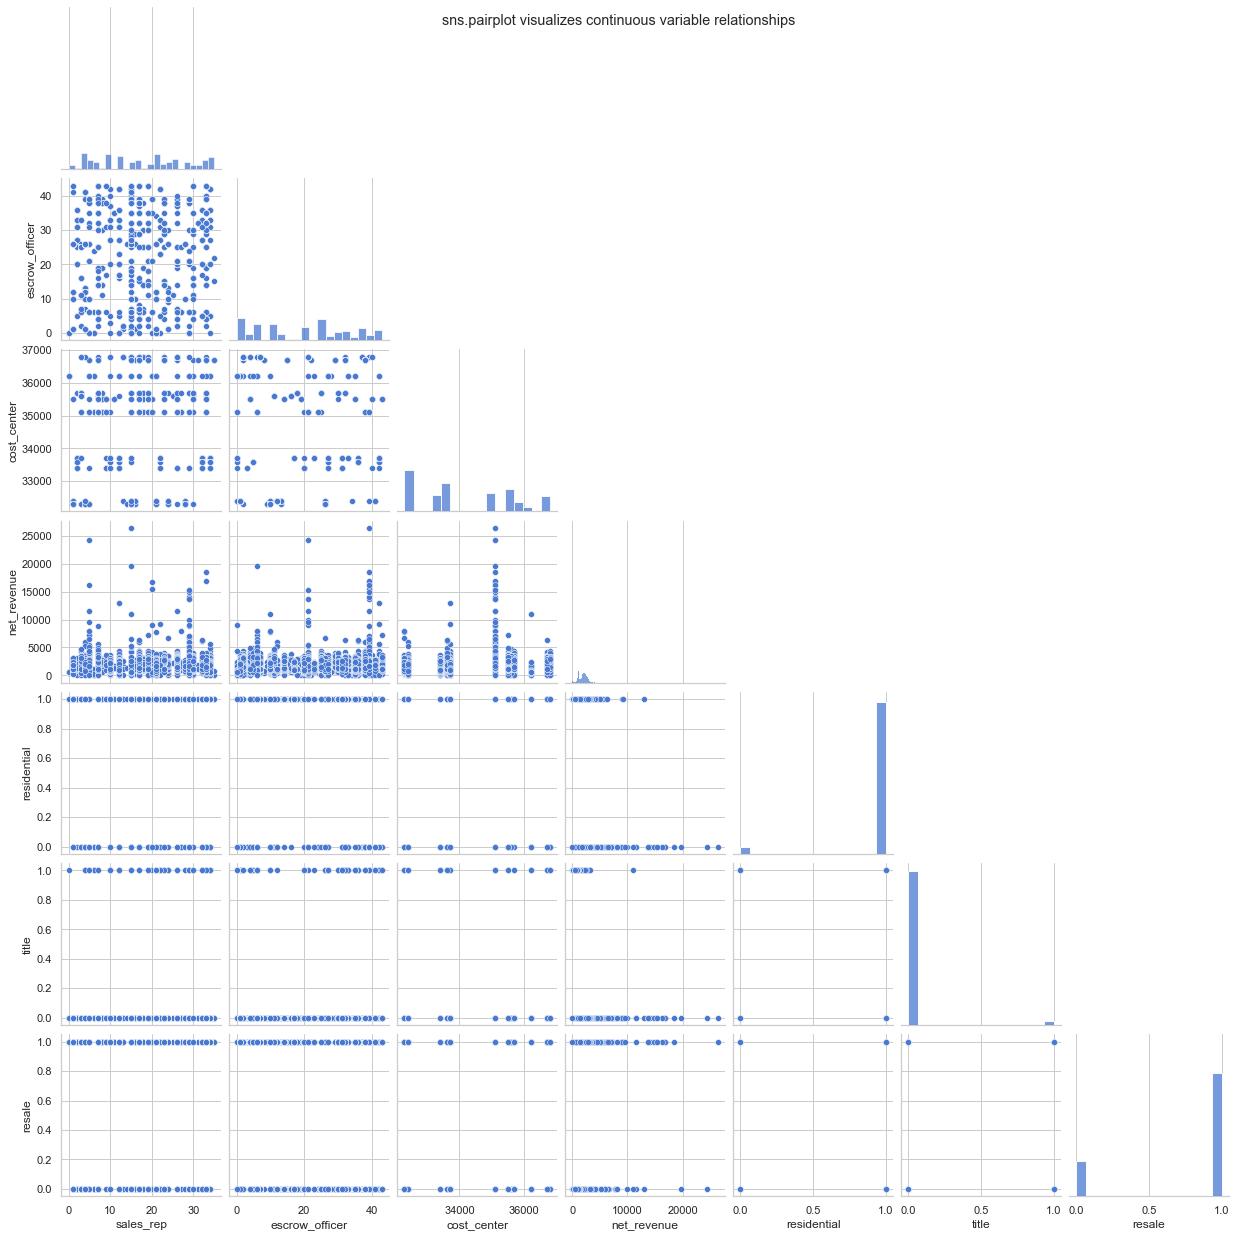

In [48]:
sns.pairplot(df, corner=True)
plt.suptitle("sns.pairplot visualizes continuous variable relationships")
plt.show()

##### No linear realtionship exist

## Train, Validate, Test

In [56]:
#setup x,y split variables
X_train = train[['net_revenue', 'cost_center', 'sales_rep', 'escrow_officer']]
y_train = train.net_revenue
X_validate = validate[['net_revenue', 'cost_center', 'sales_rep', 'escrow_officer']]
y_validate = validate.net_revenue
X_test = test[['net_revenue', 'cost_center', 'sales_rep', 'escrow_officer']]
y_test = test.net_revenue

In [57]:
#print of x, y variables shape.
print(X_train.shape,y_train.shape)
print(X_validate.shape,y_validate.shape)
print(X_test.shape,y_test.shape)

(5427, 4) (5427,)
(2326, 4) (2326,)
(1939, 4) (1939,)


## Model on Classification

#### Baseline

In [67]:
baseline = y_train.mode()
matches_baseline_prediction = y_train == 0
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {baseline_accuracy}")

Baseline accuracy: 0.0


In [68]:
#### Decision Tree

#Create the model
dt = DecisionTreeClassifier(max_depth=3, random_state=123)
#Fit the model
dt.fit(X_train, y_train)
#Use the model
dt.predict(X_train)
#prediction, accuracy, & class report evaluations
get_metrics_bin(dt, X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [60]:
#### Random Forest

#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
max_depth=8, random_state=123)
#Fit the Model
rf.fit(X_train, y_train)
#Use the Model
y_pred = rf.predict(X_train)
#prediction, accuracy, & class report evaluations
get_metrics_bin(rf, X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [61]:
#### KNN

#Create the model
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform')
#Fit the model
knn.fit(X_train, y_train)
#Use the model
y_pred = knn.predict(X_train)
#prediction, accuracy, & class report evaluations
get_metrics_bin(knn, X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [62]:
#### LogRegression

#Create the model
log_reg = LogisticRegression(C=1, random_state=123, intercept_scaling=1, solver='lbfgs')
#Fit the model
log_reg.fit(X_train, y_train)
#Use the model
y_pred = log_reg.predict(X_train)
#prediction, accuracy, & class report evaluations
get_metrics_bin(log_reg, X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [63]:
get_metrics_bin(rf, X_validate, y_validate)

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

In [ ]:
get_metrics_bin(rf, X_test, y_test)